In [1]:
import pandas as pd
from posixpath import join
import numpy as np
import random
from numpy import count_nonzero as nnz
from collections import defaultdict
from IPython.display import display
from IPython.display import Image
 
# note: ds_home is the base folder for the images
ds_home = "/mnt/datasets/uc5/std-dataset/image"

# some preprocessed files
base_path = "/mnt/datasets/uc5/UC5_pipeline_forked/experiments_eddl/mnt/datasets/uc5/UC5_pipeline_forked/experiments_eddl/eddl_ext_CNN_20tags"
# raw reports processed
ds = pd.read_csv( "/mnt/datasets/uc5/UC5_pipeline_forked/experiments_eddl/reports_raw.tsv", sep="\t", na_filter=False )


subset with exactly 1 images: (446, 1)


,image_filename
id,
2122,CXR2122_IM-0747-1001.png
3718,CXR3718_IM-1856-2001.png
2250,CXR2250_IM-0844-1001.png
2085,CXR2085_IM-0716-2001.png
484,CXR484_IM-2108-1001.png
...,...
1761,CXR1761_IM-0497-1001.png
1328,CXR1328_IM-0211-3001.png
586,CXR586_IM-2182-1001.png


*** 1064 ***
0/1


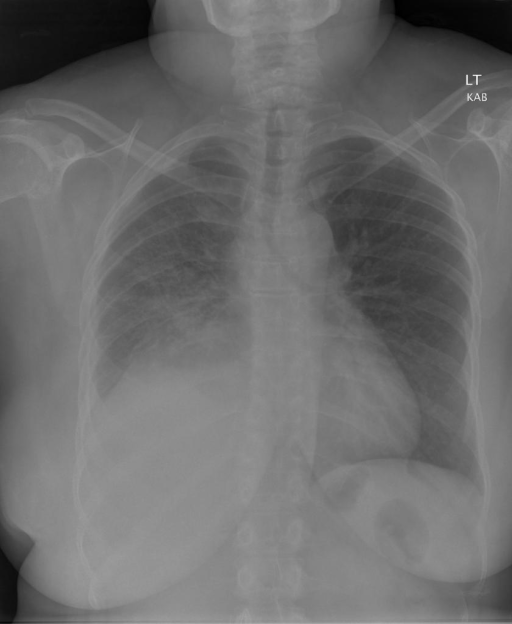

*** 740 ***
0/1


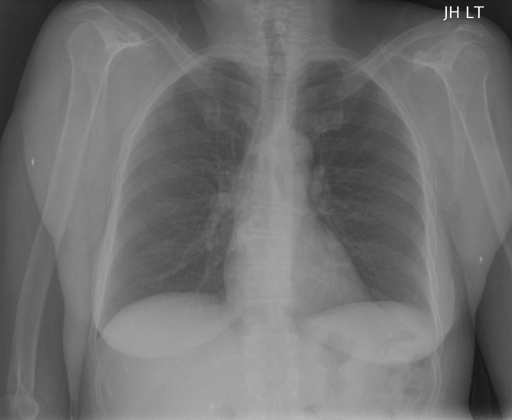

*** 3213 ***
0/1


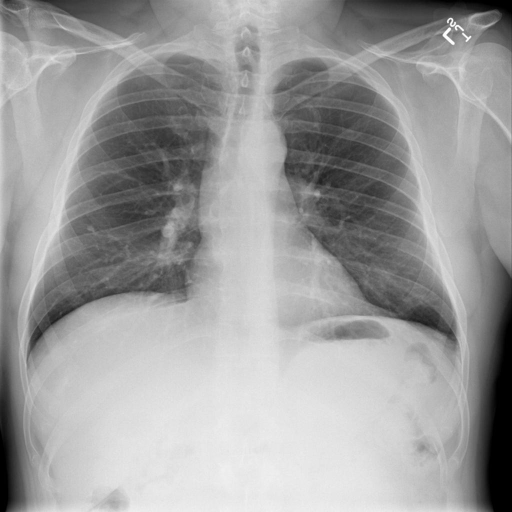

*** 3963 ***
0/1


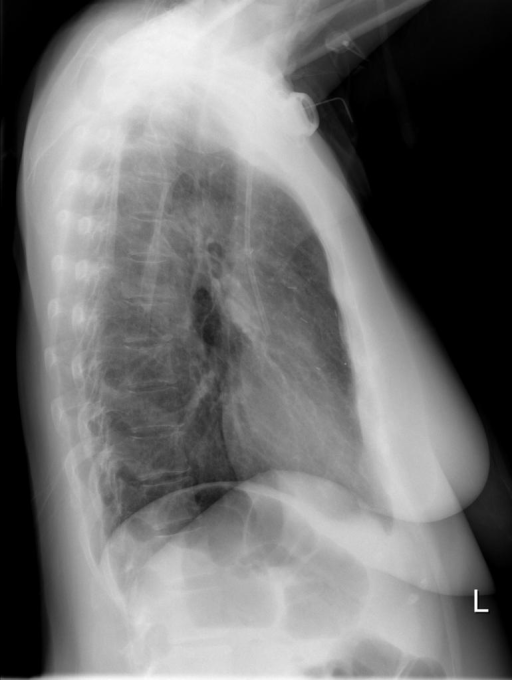

*** 2122 ***
0/1


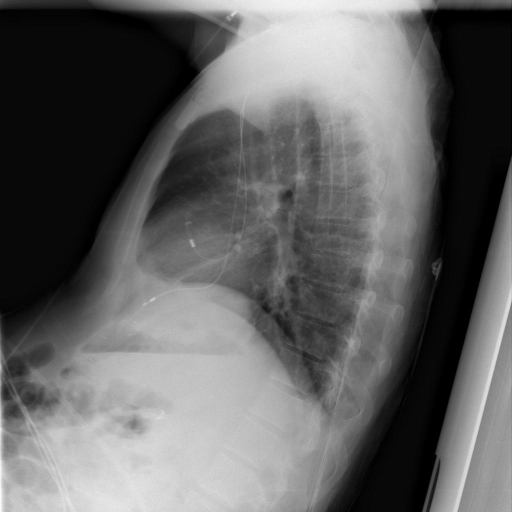

*** 1969 ***
0/1


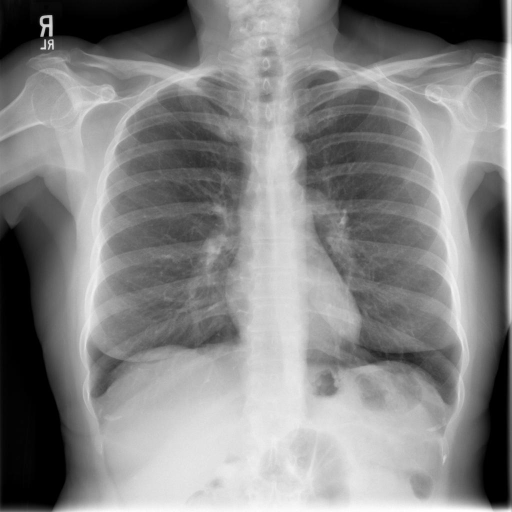

*** 1275 ***
0/1


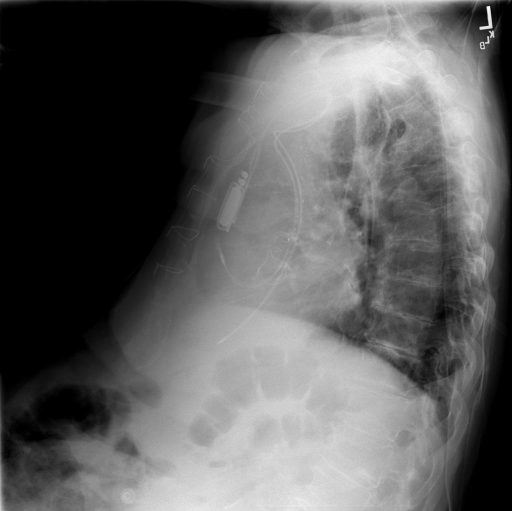

*** 454 ***
0/1


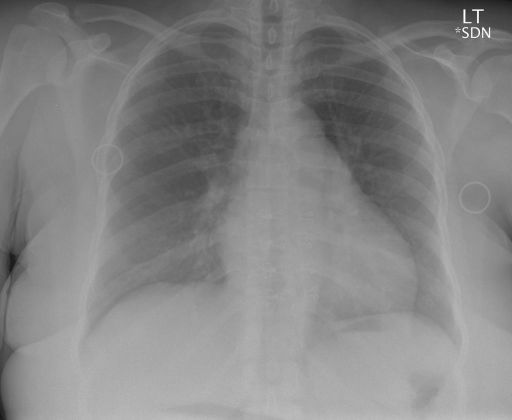

*** 1036 ***
0/1


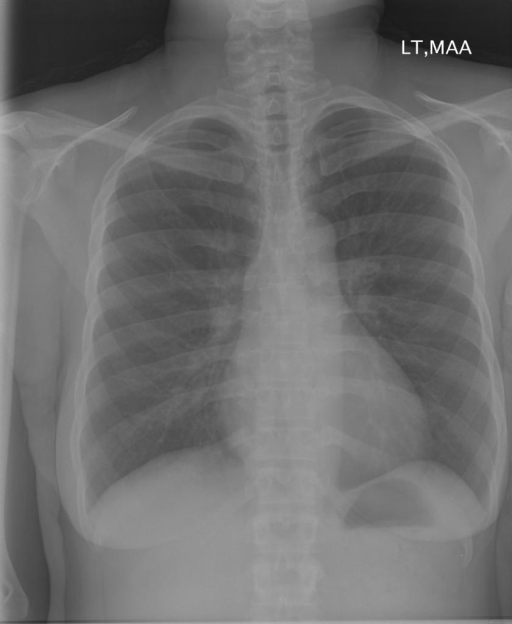

*** 1357 ***
0/1


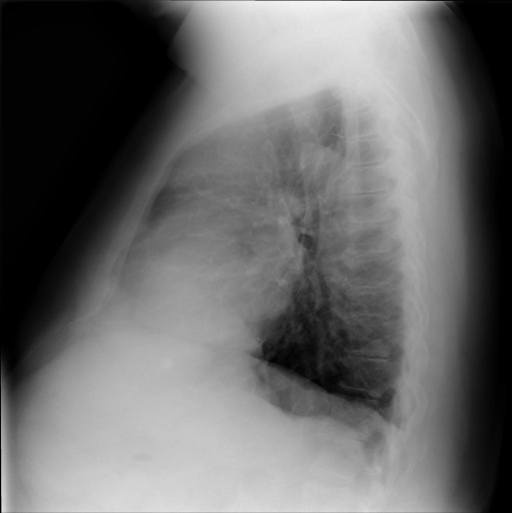

In [3]:
# display some random images associated to studies with n_images
n_images = 1
sds = ds.loc[ds.n_images == n_images, ["id", "image_filename"]].set_index("id")
print(f"subset with exactly {n_images} images: {sds.shape}")
display(sds)

# select n_samples random images
n_samples = 10
idx = random.sample(list(sds.index.values), n_samples)
# idx = [1170,42,2177]

for row in sds.loc[idx].itertuples():
    print(f"*** {row[0]} ***")
    filenames = sorted([join(ds_home, fn) for fn in row.image_filename.split(";")])
    # ipyplot.plot_images(filenames, img_width=100)
    for i, fn in enumerate(filenames):
        print(f"{i}/{len(filenames)}")
        display(Image(fn, width=224, height=224))



inspect some random samples

In [4]:
display(ds.loc[:, ["id", "major_mesh", "image_filename", "n_images"]])  # these are the columns used in this notebook

,id,major_mesh,image_filename,n_images
0,2122,Implanted Medical Device/thorax/left,CXR2122_IM-0747-1001.png,1
1,2502,Opacity/lung/middle lobe/right/focal;Markings/...,CXR2502_IM-1027-1001-0001.png;CXR2502_IM-1027-...,2
2,435,normal,CXR435_IM-2075-1001.png;CXR435_IM-2075-2001.png,2
3,3718,Pulmonary Artery/prominent/mild;Surgical Instr...,CXR3718_IM-1856-2001.png,1
4,1847,Calcified Granuloma/mediastinum/large;Calcifie...,CXR1847_IM-0550-1001.png;CXR1847_IM-0550-2001.png,2
...,...,...,...,...
3950,1926,No Indexing,CXR1926_IM-0600-1001.png;CXR1926_IM-0600-2001.png,2
3951,670,Atherosclerosis/aorta;Cardiomegaly/mild,CXR670_IM-2244-85049001.png;CXR670_IM-2244-850...,2
3952,3580,normal,CXR3580_IM-1760-1001.png;CXR3580_IM-1760-2001.png,2
3953,1522,normal,CXR1522_IM-0338-0001-0002.png,1


- when there is a single image, it can be either FRONTAL or LATERAL;
- when a report has exactly two images, the first one corresponds to a FRONTAL view and the secondo one to a LATERAL view. 
- When a report is associate to more than two images, we cannot say anything about the views of the images.

In [5]:
# prepare dataset
sub = ds.loc[ds.n_images == 2]
print(sub.shape)
frontal = []
lateral = []

def separate_images(filenames):
    f = filenames.split(";")
    assert len(f) == 2
    frontal.append(f[0])
    lateral.append(f[1])

for row in sub.itertuples():
    separate_images(row.image_filename)
#subset.image_filename.apply(lambda filenames: separate_images(filenames))

print(f"frontal: {len(frontal)}")
print(f"lateral: {len(lateral)}")



(3208, 13)
frontal: 3208
lateral: 3208


frontal


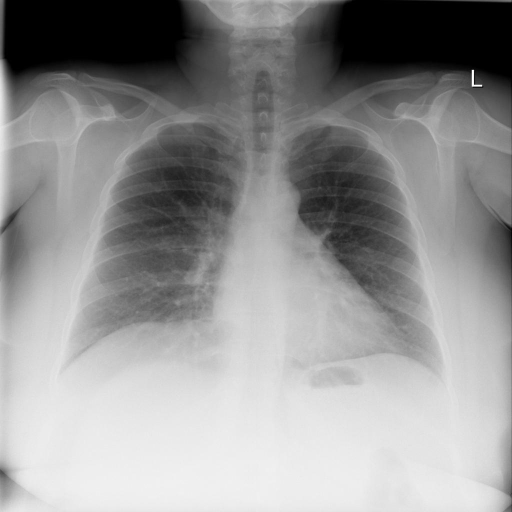

lateral


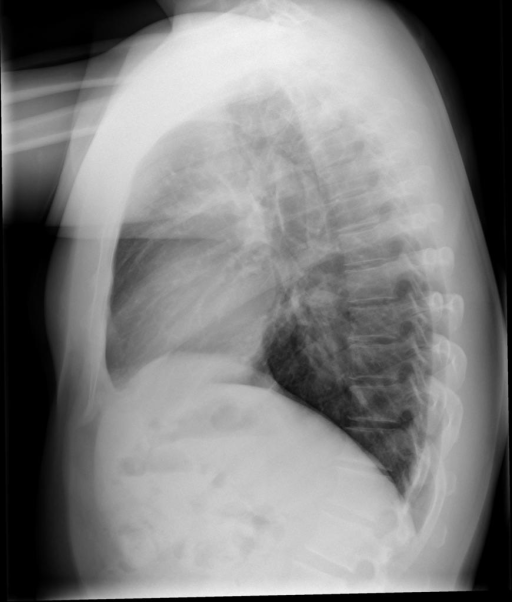

In [7]:
# check
print('frontal')
fn = join(ds_home, random.sample(frontal, 1)[0])
display(Image(fn, width=224, height=224))

print('lateral')
fn = join(ds_home, random.sample(lateral, 1)[0])
display(Image(fn, width=224, height=224))

In [ ]:
def prepare_ecvl_dlds(train, valid, test, y_train, y_valid, y_test):
     d = {
        "name"        : "ECVL dataset for UC5",
        "description" : description,
        "classes"     : [], 
        "images"      : [],
        "split"       : dict(training = list(range(n_train)), 
                            validation = list(range(n_train, n_train + n_valid)), 
                            test=list(range(n_train + n_valid, len(ds))))
    }


import random
from sklearn.model_selection import train_test_split, StratifiedKFold

frontal_lab = [1, 0]
lateral_lab = [0, 1]

X = frontal + lateral
y = [1] * len(frontal) + [2] * len(lateral)

shuffle_seed = 11
train_p = 0.7
valid_p = 0.1
test_p = 1 - train_p - valid_p
print(f"X={len(X)}, Y={len(y)}")
print(f"expected train={len(X)*train_p}, val={len(X)*valid_p}, test={len(X)*test_p}")

X = np.array(frontal + lateral)
y = np.array([1] * len(frontal) + [0] * len(lateral))
assert X.shape[0] == 2 * sub.shape[0]
assert y.shape[0] == 2 * sub.shape[0]
skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=shuffle_seed)
for i, (others, test) in enumerate(skf.split(X, y)):
    print(15 * "=" + f" {i+1}/{skf.n_splits}")
    print(f"train/test: label distribution, others -  {np.bincount(y[others])}   |   test -  {np.bincount(y[test])}")
    test_p = 1 / skf.n_splits
    train, valid = train_test_split(others, test_size=valid_p/(1-test_p), shuffle=True, stratify=y[others], random_state=shuffle_seed+i)
    print(f"train/val:  label distribution, train -  {np.bincount(y[train])}   |   validation -  {np.bincount(y[valid])}")
    assert len(train) + len(valid) == len(others)
    #prepare_ecvl_dlds(X_train, X_valid, X[test], y_train, y_valid, y[test])
